## Import Data and Libraries


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize      
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction import text
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB


In [3]:
# bring in dataset from data folder in git
df = pd.read_csv('./data/data.csv')

In [4]:
# Display first 5 rows of Dataframe to make sure it came through correctly
df.head()

,subreddit,selftext,title
0,personalfinance,My gf's father supposedly had a life insuranc...,How do I find unclaimed life insurance money?
1,personalfinance,Does anyone know with the cares act if I would...,401k withdrawal to invest in an IRA
2,personalfinance,So my best friend would like to give me 100k t...,Best friend wants to give me money to put into...
3,personalfinance,I’m a 28 year old male. I’m a new homeowner (i...,Should I take advantage of the no penalty opti...
4,personalfinance,"Hi all. Im a frequent user on the popular ""sel...",Am I Falling for a scam on LetGo?


In [5]:
# Replace rows that that have [removed] in the selftext with NaN so we can drop it easily
df['selftext'] = np.where(df['selftext'] == '[removed]',np.nan,df['selftext'])

In [6]:
# Drop all rows with no text information in the post
df.dropna(inplace=True)

In [7]:
# started with 6000 rows. Let's see where we are now.
df.shape

(4924, 3)

Run a Lemmatizer to test on dataframe. 

In [8]:
#Import and instantiate Lemmatizer
# from nltk.stem import WordNetLemmatizer


# lemmatizer = WordNetLemmatizer()

# def lemma(text):
#     return ' '.join([lemmatizer.lemmatize(w) for w in text.split()])

# df['selftext'] = df['selftext'].apply(lemma)

Lemmatizer made model more overfit, so I have coded it out. 

In [9]:
# create a dataframe just for our first subreddit so we can pull popular words from this list separate from the other
df_sub1 = df[df['subreddit'] == 'personalfinance']
df_sub1.shape

(2522, 3)

In [10]:
# create a dataframe just for our second subreddit so we can pull popular words from this list separate from the other
df_sub2 = df[df['subreddit'] == 'investing']
df_sub2.shape

(2402, 3)

# Data Processing

In [11]:
# set y as predict column, and X to text from site
X = df['selftext']
y = df['subreddit']

In [12]:
# check to see the balance of the predicted class
y.value_counts(normalize=True)

personalfinance    0.512185
investing          0.487815
Name: subreddit, dtype: float64

In [13]:
# Set our Training and Testing Data Sets
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42, stratify=y)

In [14]:
# Put together a stop list to toggle if we need it
stop_list = ['https','com','about','all','am','from','how','like','me','there','was','wa','www','an','ha']

# CountVectorizer Pipeline

In [61]:
# Initialize a pipe with CountVectorizer & LogisticRegression
pipe1 = Pipeline([
    ('cvec' , CountVectorizer()),
    ('lr' , LogisticRegression(solver='liblinear'))
])

In [66]:
# Set hyperparameters for pipeline
pipe1_params = {
#     'cvec__stop_words' : stop_list,
    'cvec__max_features' : [3500, 4000, 4500, 5000],
    'cvec__min_df' : [2],
    'cvec__max_df' : [.7, .8, .85],
    'cvec__ngram_range' : [(1, 2), (1, 3)],
    'lr__C' : [1.0,.9,.8]
}

In [67]:
# Instantiate GridSearchCV for 1st Pipe.

gs1 = GridSearchCV(pipe1, 
                  pipe1_params, 
                  cv = 5
                 ) 

In [68]:
# Fit GridSearch to training data.
gs1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [19]:
# Find our best score
gs1.best_score_

0.890607684155326

In [20]:
# find our best estimator
gs1.best_estimator_

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.7,
                                 max_features=5000, min_df=2,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                           

In [21]:
# Specifically list out best parameters used 
gs1.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 3)}

In [22]:
# Set our best estimator as a model
gs_model1 = gs1.best_estimator_

In [23]:
# run .score on the Training Data
gs_model1.score(X_train, y_train)

0.9935012185215272

In [24]:
# run the .score on the Testing Data
gs_model1.score(X_test, y_test)

0.8878960194963444

In [25]:
# get our predicted y values from the testing data
y_pred = gs_model1.predict(X_test)

## Confusion Matrix for 1st Model

In [57]:
# setup confusion matrix 
cm = confusion_matrix(y_test,y_pred)
cm

array([[543,  58],
       [ 80, 550]])

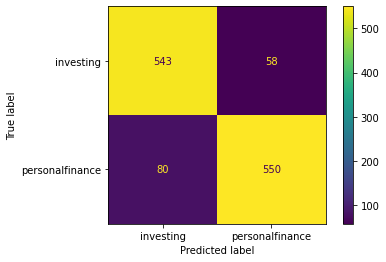

In [58]:
# run plot_confusion_matrix to visualize matrix
plot_confusion_matrix(
    gs_model1,
    X_test,
    y_test,
    values_format='2g'
);

In [115]:
# Print results of confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f' true neg {tn}, false pos {fp}, false neg {fn}, true pos {tp}')

 true neg 543, false pos 58, false neg 80, true pos 550


In [116]:
# Accuracy is True Predictions over total attempts
accuracy = (tn+tp)/(fp+tp+tn+fn)
misclass = 1 - accuracy
recall = tp / (tp+fn)
spec = tn / (tn+fp)
prec = tp / (tp + fp)
print(f'My Accuracy Rate is {round(accuracy,4) * 100}%')
print(f'My Misclassification Rate is {round(misclass,3) * 100}%')
print(f'My Recall Rate is {round(recall,3) * 100}%')
print(f'My Specificity Rate is {round(spec,4) * 100}%')
print(f'My Precision Rate is {round(prec,3) * 100}%')

My Accuracy Rate is 88.79%
My Misclassification Rate is 11.200000000000001%
My Recall Rate is 87.3%
My Specificity Rate is 90.35%
My Precision Rate is 90.5%


We are able to predict with nearly 89% accuracy the correct source of the reddit posts. 

# TFIDF PIPE

In [29]:
# Here we will setup a second pipeline, with parameter list for iteration, and the gridsearch
pipe2 = Pipeline([
    ('tvec' , TfidfVectorizer()),
    ('lr' , LogisticRegression())
])

pipe2_params = {
#     'cvec__stop_words' : english,
    'tvec__max_features' : [50, 100, 150],
    'tvec__min_df' : [3, 4,5],
    'tvec__max_df' : [.2, .3, .4],
    'tvec__norm' : ['l2'],
    'tvec__ngram_range' : [(1, 1)]}

gs2 = GridSearchCV(pipe2, 
                  pipe2_params, 
                  cv = 5
                 ) 

In [30]:
# Fit the second gridsearch with the same training data
gs2.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [31]:
# Find the best score for the second pipeline
gs2.best_score_

0.8759856394233767

In [32]:
# Find the best estimator for the second pipeline
gs2.best_estimator_

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.2, max_features=150,
                                 min_df=3, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,

In [33]:
#get the best parameters for the second pipeline
gs2.best_params_

{'tvec__max_df': 0.2,
 'tvec__max_features': 150,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2'}

In [34]:
# Set best estimator to a second model and evaluate training and testing scores.
gs_model2 = gs2.best_estimator_

print(f'train score: {gs_model2.score(X_train, y_train)}')

print(f'test score: {gs_model2.score(X_test, y_test)}')

train score: 0.8911454102355808
test score: 0.8708367181153533


In [35]:
# get the second set of prediction y values for X_test set
y_pred2 = gs_model2.predict(X_test)

## TfiDf Confusion Matrix

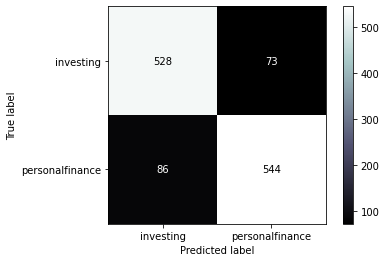

In [36]:
plot_confusion_matrix(
    gs_model2,
    X_test,
    y_test,
    cmap='bone',
    
    values_format='2g'
);

In [37]:
#Print out Confusion Matrix results
tn, fp, fn, tp = confusion_matrix(y_test, y_pred2).ravel()
print(f' true neg {tn}, false pos {fp}, false neg {fn}, true pos {tp}')

 true neg 528, false pos 73, false neg 86, true pos 544


In [38]:
# Accuracy is True Predictions over total attempts
accuracy = (tn+tp)/(fp+tp+tn+fn)
misclass = 1 - accuracy
recall = tp / (tp+fn)
spec = tn / (tn+fp)
prec = tp / (tp + fp)
print(f'My Accuracy Rate is {round(accuracy,4) * 100}%')
print(f'My Misclassification Rate is {round(misclass,3) * 100}%')
print(f'My Recall Rate is {round(recall,3) * 100}%')
print(f'My Specificity Rate is {round(spec,4) * 100}%')
print(f'My Precision Rate is {round(prec,3) * 100}%')

My Accuracy Rate is 87.08%
My Misclassification Rate is 12.9%
My Recall Rate is 86.3%
My Specificity Rate is 87.85%
My Precision Rate is 88.2%


In [96]:
# Produce DataFrame with columns for each word in TfidVectorizer to create word occurance visualizations

tvec = TfidfVectorizer(
    max_df=0.2,
    max_features=150,
#     tokenizer=word_tokenize,
    min_df=5,
    ngram_range=(1, 1),
    norm='l2',
    stop_words=['your','which','when','we','want','ve','their','by','com','www','https','into','stock']
)

df_tvec = pd.DataFrame(tvec.fit_transform(X_train).toarray(),
                  columns=tvec.get_feature_names())

sub1_td = pd.DataFrame(tvec.transform(df_sub1['selftext']).toarray(),
                  columns=tvec.get_feature_names())

sub2_td = pd.DataFrame(tvec.transform(df_sub2['selftext']).toarray(),
                  columns=tvec.get_feature_names())

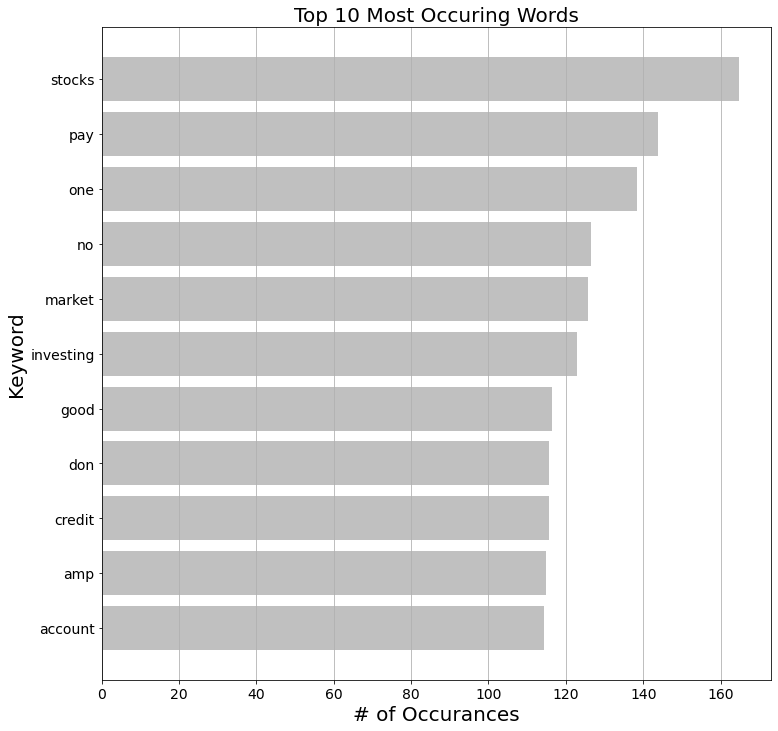

In [113]:
# Plot top occuring words used in both subreddits
plt.figure(figsize=(12,12))
plt.title('Top 10 Most Occuring Words',fontsize=20)
plt.grid(b=True, axis='x')
plt.ylabel('Keyword', fontsize=20)
plt.xlabel('# of Occurances', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.barh(df_tvec.loc[:, (df_tvec.sum(axis=0) > 114)].columns
        ,df_tvec.loc[:, (df_tvec.sum(axis=0) > 114)].sum().sort_values()
         , color='#C0C0C0'
       );


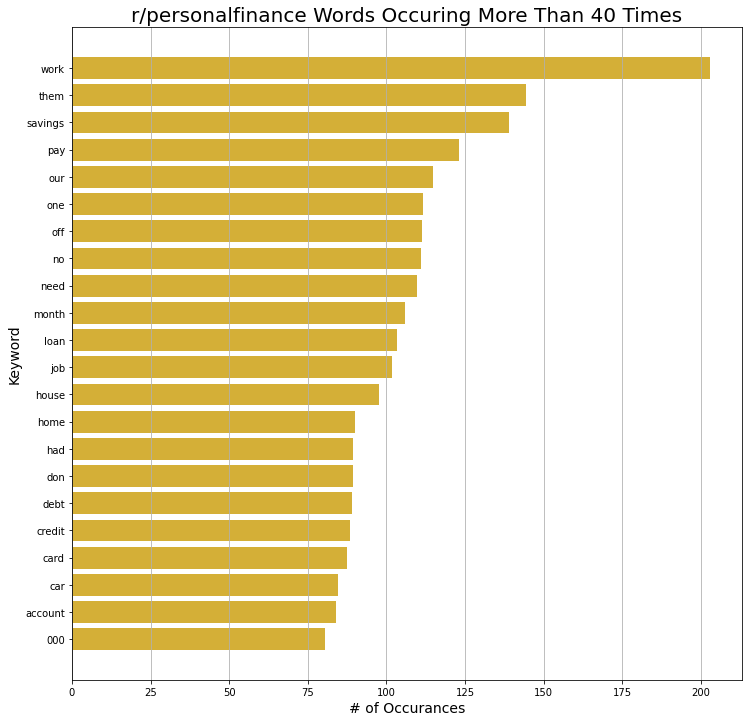

In [109]:
# plot top words occuring in the first subreddit
plt.figure(figsize=(12,12))
plt.title('r/personalfinance Words Occuring More Than 40 Times',fontsize=20)
plt.grid(b=True, axis='x')
plt.ylabel('Keyword', fontsize=14)
plt.xlabel('# of Occurances', fontsize=14)

plt.barh(sub1_td.loc[:, (sub1_td.sum(axis=0) > 80)].columns
        ,sub1_td.loc[:, (sub1_td.sum(axis=0) > 80)].sum().sort_values()
         , color='#D4AF37'
       );

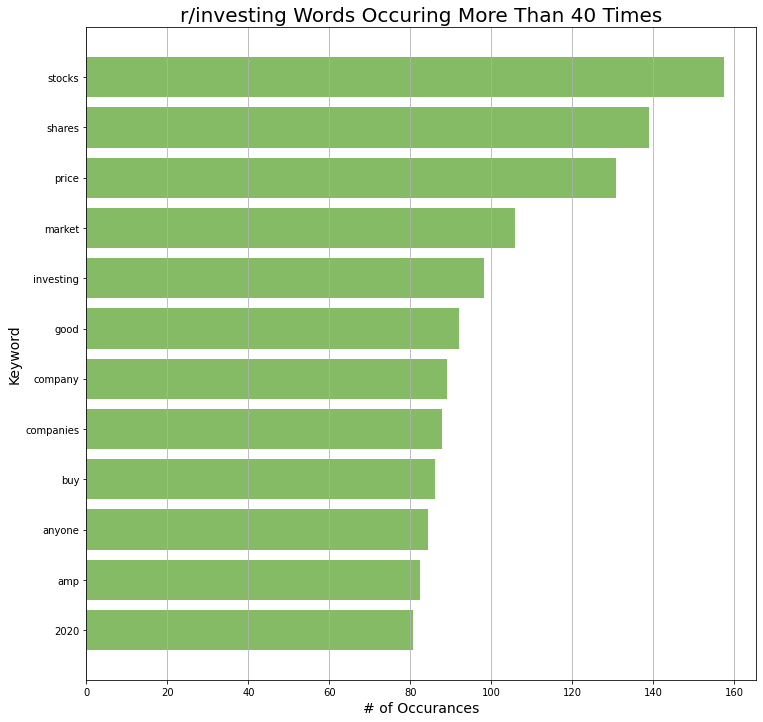

In [108]:
# plot top words occuring in the second subreddit

plt.figure(figsize=(12,12))
plt.title('r/investing Words Occuring More Than 40 Times',fontsize=20)
plt.grid(b=True, axis='x')
plt.ylabel('Keyword', fontsize=14)
plt.xlabel('# of Occurances', fontsize=14)

plt.barh(sub2_td.loc[:, (sub2_td.sum(axis=0) > 80)].columns
        ,sub2_td.loc[:, (sub2_td.sum(axis=0) > 80)].sum().sort_values()
         , color='#85bb65'
       );

# Naîve Bayes

In [46]:
# Instantiate Count Vectorizer with same best_params from above
cv = CountVectorizer(max_df=0.85,max_features=3000,min_df=2,ngram_range=(1, 2))

#refit new CountVectorizer with X_train and transform X_train and X_Test for use with Naive Bayes Model
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

#tranform corpus
X_train_cv = X_train_cv.toarray()
X_test_cv = X_test_cv.toarray()

#Instantiate Naive Bayes Multinomial Model
nbayes = MultinomialNB()
nbayes.fit(X_train_cv, y_train)

# Print the Train and Test scores
print(f'Naive Bayes Train Score: {nbayes.score(X_train_cv,y_train)}')
print(f'Naive Bayes Test Score: {nbayes.score(X_test_cv,y_test)}')

Naive Bayes Train Score: 0.9111833197942053
Naive Bayes Test Score: 0.8887083671811535


## Random Forest

In [54]:
# Run a random forest to see if it provides a better fit
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


In [52]:
rf = RandomForestClassifier().fit(X_train_cv,y_train)
cross_val_score(rf,X_train_cv, y_train).mean()

0.8822179683231204

In [53]:
cross_val_score(rf,X_test_cv, y_test).mean()

0.8480991409104375

Random Forest is more overfit than Logistic Regression and Naive Bayes